In [115]:
import urllib.request
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [116]:
import warnings
warnings.filterwarnings('ignore')# Suppress all warnings



In [117]:
#Data loading from Google drive
def load_csv_from_drive(file_id):
    url = f'https://drive.google.com/uc?id={file_id}'
    response = urllib.request.urlopen(url)
    data = response.read()
    df = pd.read_csv(io.BytesIO(data))
    return df

#Google drive Link
customers_file_id = "1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
products_file_id = "1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0"
transactions_file_id = "1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"

#Creating DataFrame
cust_df = load_csv_from_drive(customers_file_id)
prod_df = load_csv_from_drive(products_file_id)
transactions_df = load_csv_from_drive(transactions_file_id)

In [118]:
all_merged = transactions_df.merge(cust_df, on="CustomerID").merge(prod_df, on="ProductID")


#Feature Engineering

In [119]:
# Convert 'SignupDate' to datetime to extract year
all_merged['SignupDate'] = pd.to_datetime(all_merged['SignupDate'])
all_merged['SignupYear'] = all_merged['SignupDate'].dt.year

In [120]:
# Create customer features: total spending, purchase frequency, and product variety
customer_features = all_merged.groupby('CustomerID').agg({
    'Region': 'first',  # assuming region is the same for all transactions
    'SignupYear': 'first',  # assuming signup year is the same for all transactions
    'TotalValue': 'sum',  # total spending by the customer
    'TransactionDate': 'nunique',  # number of unique transaction dates (purchase frequency)
    'ProductID': 'nunique'  # number of unique products purchased
}).reset_index()

In [121]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler,StandardScaler

# Using MinMaxScaler for optimum results
scaler = MinMaxScaler()
customer_features_scaled = scaler.fit_transform(customer_features[['TotalValue', 'TransactionDate', 'ProductID']])


In [122]:
# Add profile features (Region, SignupYear) to the scaled data
customer_features_scaled = pd.DataFrame(customer_features_scaled, columns=['TotalValue', 'TransactionDate', 'ProductID'])
customer_features_scaled['Region'] = customer_features['Region']
customer_features_scaled['SignupYear'] = customer_features['SignupYear']

customer_features_scaled.head()

,TotalValue,TransactionDate,ProductID,Region,SignupYear
0,0.308942,0.4,0.444444,South America,2022
1,0.168095,0.3,0.333333,Asia,2022
2,0.249541,0.3,0.333333,South America,2024
3,0.497806,0.7,0.777778,South America,2022
4,0.184287,0.2,0.222222,Asia,2022


In [123]:
# Clustering: Test different values of k and calculate DB Index
db_index_values = []
k_range = range(2, 11)  # Testing for number of clusters from 2 to 10


# K means clustering

In [124]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features_scaled[['TotalValue', 'TransactionDate', 'ProductID']])
    labels = kmeans.labels_
    db_index = davies_bouldin_score(customer_features_scaled[['TotalValue', 'TransactionDate', 'ProductID']], labels)
    db_index_values.append(db_index)


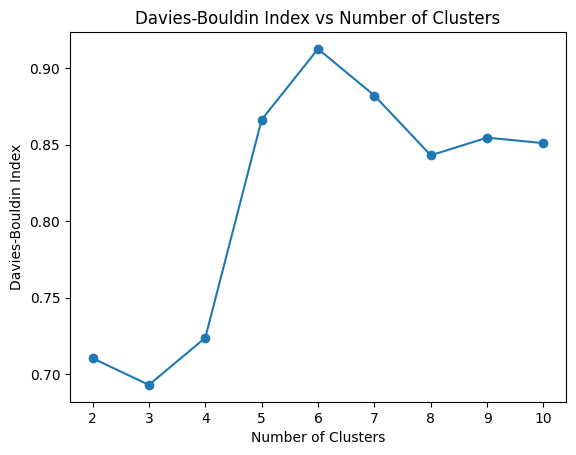

In [125]:
plt.plot(k_range, db_index_values, marker='o')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.show()

In [126]:
optimal_k = k_range[db_index_values.index(min(db_index_values))]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 3


In [127]:
# Perform K-Means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features_scaled['Cluster'] = kmeans.fit_predict(customer_features_scaled[['TotalValue', 'TransactionDate', 'ProductID']])


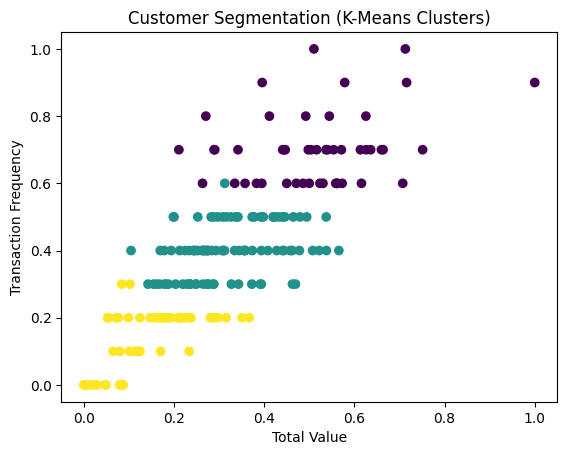

In [128]:
# Visualizing clusters using 2D scatter plot (first two features)
plt.scatter(customer_features_scaled['TotalValue'], customer_features_scaled['TransactionDate'], c=customer_features_scaled['Cluster'], cmap='viridis')
plt.title('Customer Segmentation (K-Means Clusters)')
plt.xlabel('Total Value')
plt.ylabel('Transaction Frequency')
plt.show()


#Davies-Bouldin Index

In [129]:
# Calculate DB Index for the final clustering
final_db_index = davies_bouldin_score(customer_features_scaled[['TotalValue', 'TransactionDate', 'ProductID']], customer_features_scaled['Cluster'])
print(f"Final Davies-Bouldin Index: {final_db_index}")

Final Davies-Bouldin Index: 0.6929586106732427


#Silhouette score

In [130]:
from sklearn.metrics import silhouette_score

# Silhouette score for KMeans
silhouette_avg = silhouette_score(customer_features_scaled[['TotalValue', 'TransactionDate', 'ProductID']], customer_features_scaled['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.4637254821521127


#Principal Component Analysis (PCA)
PCA is an unsupervised learning algorithm technique used to examine the interrelations among a set of variables.


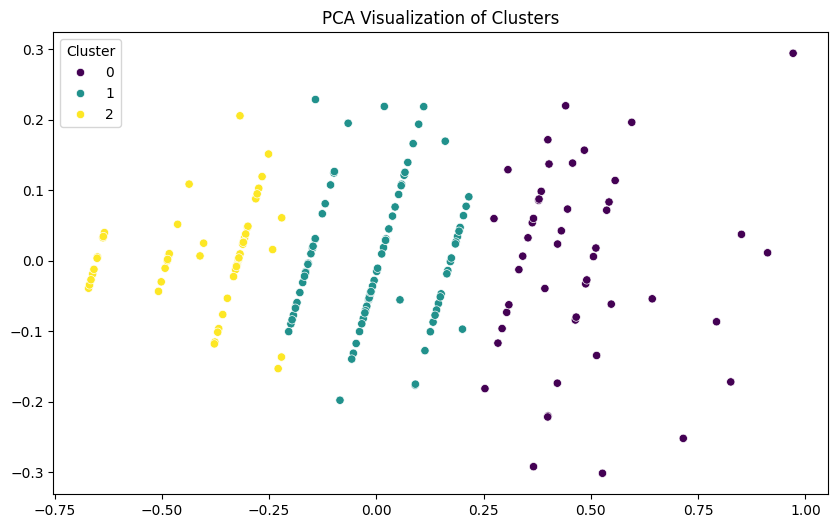

In [131]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_features_scaled[['TotalValue', 'TransactionDate', 'ProductID']])

# Visualize the clusters in 2D using PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=customer_features_scaled['Cluster'], palette='viridis')
plt.title('PCA Visualization of Clusters')
plt.show()
